In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import random

# Data Filtering

In [2]:
df = pd.read_csv('clustering_data.csv', low_memory=False)
df = df[df["StateName"]== "TELANGANA"]
df = df.loc[:, ["Latitude","Longitude"]]
df = df.astype({"Latitude": float, "Longitude": float})
df.drop_duplicates(inplace=True)
df = df.reset_index().drop(['index'], axis=1)
df = df.dropna()
# print(df)

## Filtering the points that are in Telangana

The following code loads India states boundaries and extract the Telangana boundary. It then transforms the points in the datasets into geometric coordinates and selects only those points located within Telangana.

In [3]:
India  = gpd.read_file("gadm41_IND_shp/gadm41_IND_1.shp")
Telangana = India[India["NAME_1"] == 'Telangana']

geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
geo_points = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
data_df = geo_points[geo_points.within(Telangana.geometry.union_all())]

data =[[x[0], x[1]] for x in data_df.values.tolist()]

# Defining different Distance metrics

In [4]:
def Minkowski_distance( p1, p2):
    if len(p1) != len(p2) or len(p1) == 0:
        return -1
    n= len(p1)
    sum_n=0

    for x,y in zip(p1,p2):
        sum_n += abs(x-y)**n

    distance = sum_n**(1/n)
    return distance

def Manhattan_distance( p1, p2):
    if len(p1) != len(p2) or len(p1) == 0:
        return -1
        
    sum_n=0
    for x,y in zip(p1,p2):
        sum_n += abs(x-y)

    distance = sum_n
    return distance

def Euclidean_distance( p1, p2):
    if len(p1) != len(p2) or len(p1) == 0:
        return -1
    n= 2
    sum_n=0

    for x,y in zip(p1,p2):
        sum_n += abs(x-y)**n

    distance = sum_n**(1/n)
    return distance

def distance(index, p1, p2):
    match index:
        case 1:
            return Manhattan_distance(p1,p2)
        case 2:
            return Euclidean_distance(p1,p2)
        case 3:
            return Minkowski_distance(p1,p2)


# Function to plot the clusters after each iteration

The following function is used to plot the clusters after each iteration although I comented out that part of the code in the further cells

In [5]:
def plot(clusters, axs, c):
    clusters_x = clusters[0]
    clusters_y = clusters[1]
    colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan","magenta", "yellow", "teal", "navy", "maroon", "lime", "gold", "indigo", "coral", "turquoise"]

    Telangana.plot(ax=axs, color='lightblue', edgecolor='black')
    
    for i in range(c):
        points_df = pd.DataFrame({'Latitude': clusters_x[i], 'Longitude': clusters_y[i]})
        geometry = [Point(xy) for xy in zip(points_df['Longitude'], points_df['Latitude'])]
        geo_points = gpd.GeoDataFrame(points_df, geometry=geometry, crs="EPSG:4326")
        
        if not geo_points.empty:
            lab = 'cluster- '+str(i+1)
            geo_points.plot(ax=axs, color=colors[i], marker='o', label=lab)

    axs.legend();

# Function to assign centers

The following function assigns the centers (labels) to all the data points

In [6]:
def Assign_centers(data, centers, c, axs = None):
    Y = []
    for i in range(len(data)):
        dist = []
        for j in range(len(centers)):
            dist.append(distance(2, data[i], centers[j]))
        Y.append(dist.index(min(dist)))
    clusters_x=[]
    clusters_y=[]
    for i in range(c):
        clusters_x.append([])
        clusters_y.append([])
    for i in range(len(data)):
        clusters_x[Y[i]].append(data[i][0])
        clusters_y[Y[i]].append(data[i][1])

    if axs is not None:
        plot([clusters_x, clusters_y], axs, c)
    
    return Y

# Function to compute Centroids

The following function computes the centroids for each cluster. I had also included code to handle empty clusters, which I encountered during an initial run for some reason.

In [7]:
# def empty_cluster(centers, Y, data, i):
#     while True:
#         new_center = data[np.random.choice(len(data))]
#         if new_center not in centers:
#             centers[i] = new_center
#             return centers

def centroid_computation(data, Y, c):
    count = np.zeros(c)
    centers = np.zeros((c,len(data[0])))
    
    for i in range(len(data)):
        count[Y[i]] += 1

    # for i in range(c):
    #     if count[i] == 0:
    #         return empty_cluster(centers, Y, data, i)

    for i in range(len(data)):
        for j in range(len(data[0])):
            centers[Y[i]][j] += data[i][j]
            
    for i in range(len(centers)):
        for j in range(len(centers[0])):
            centers[i][j] /= count[i]
        
    return list(centers)

The following code implements a K‑Means clustering algorithm: it starts by randomly sampling c points from the dataset, which are assigned as the initial centers, the it loops over assigning each data point to its nearest center and recomputing the centroids of those datapoints until the labels stabilize or the number of iteration reaches 50. Once the algorithm converged, it calls Inter_distance to calculate the total sum of distances between each point and its assigned center, which is kind of a metric to measure the cluster compactness and returns this value alongside the final centers and the final labels that are assigned.

In [13]:
def Inter_distance(centers, Y, data):
    inter  = np.array([distance(2, p, centers[Y[i]])  for i, p in enumerate(data)])
    inter_distance = np.sum(inter)
    return inter_distance
    
def Kmeans(c, axs = None):
    centers = random.sample(data, c)
    if axs is None:
        Y = Assign_centers(data, centers, c)
    else:
        Y = Assign_centers(data, centers, c, axs[0])
    max_iteration = 30
    current_iteration = 0
    while current_iteration < max_iteration:
        current_iteration += 1
        centers = centroid_computation(data, Y, c)
        if axs is None:
            Y1 = Assign_centers(data, centers, c)
        else:
            Y1 = Assign_centers(data, centers, c, axs[current_iteration])
        if Y == Y1:
            break
        else:
            Y = Y1
    return Inter_distance(centers, Y, data), centers , Y

The following code runs K-means algorithmfor for values k (which is `c` in the following code) ranging from 1 to 20 and collects the corresponding intra cluster distance, and plots these values against c. The resulting curve is a decreases curve and forms an “elbow” shape, indicating very little change in compactness of cluster as c increases. In this case, the elbow has appeared around `c = 5`, suggesting it as the optimal number of clusters where adding more clusters resulting in minimal benefit.

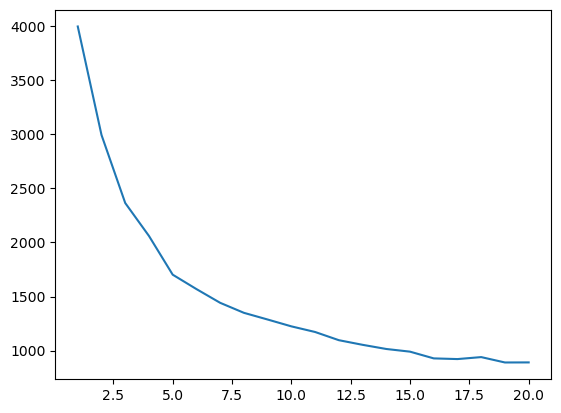

In [14]:
k = np.array(range(20)) + 1
k = list(k)
p = [Kmeans(c)[0] for c in k]
plt.plot(k, p)
plt.show()

In [ ]:
c= 5
fig, axs = plt.subplots(31, 1, figsize=(10, 200))
Y = Kmeans(c, axs)[2]

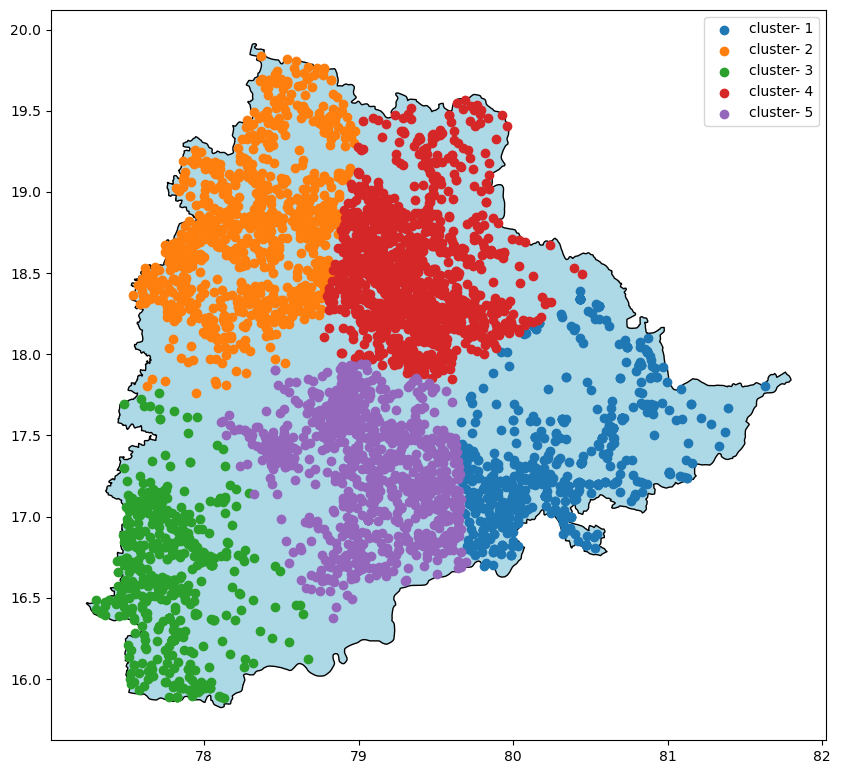

In [11]:
clusters_x=[]
clusters_y=[]
for i in range(c):
    clusters_x.append([])
    clusters_y.append([])
for i in range(len(data)):
    clusters_x[Y[i]].append(data[i][0])
    clusters_y[Y[i]].append(data[i][1])

colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan","magenta", "yellow", "teal", "navy", "maroon", "lime", "gold", "indigo", "coral", "turquoise"]

fig, axs = plt.subplots(figsize=(10, 10))
Telangana.plot( ax = axs ,color='lightblue', edgecolor='black')
for i in range(c):
    lab = 'cluster- '+str(i+1)
    axs.scatter(clusters_y[i], clusters_x[i], marker = 'o', label=lab)
axs.legend()
plt.show()

The clusters in the above plot shows how pin codes in Telangana can be grouped based on how close they are to each other on the map. Each cluster represents a group of nearby locations. These groups have formed naturally based on the way people have settled across the state. The way the clusters are shaped suggests that some areas have many pin codes close together like cities, while others are more spread out like villages or rural regions. This kind of grouping can be useful for planning services, making deliveries easier, or understanding how different areas are organized.